In [11]:
from typing import Callable

import emcee
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from scipy import optimize

In [2]:
X = np.linspace(1, 10, 10)
SIGMA = 1


def generate_data(k: float, b: float) -> np.ndarray:
    return k * X + b + np.random.normal(loc=0, scale=SIGMA, size=X.shape)


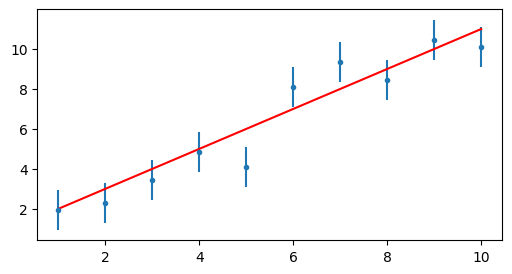

In [3]:
def plot_model(y: np.ndarray, k: float, b: float) -> Axes:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.errorbar(X, y, yerr=SIGMA, fmt=".")
    ax.plot(X, k * X + b, "r")
    return ax


_ = plot_model(y=generate_data(k=1, b=1), k=1, b=1)

In [4]:
def sample(
    logpost: Callable[[np.ndarray], float],
    theta_true: np.ndarray,
    quiet: bool = False,
) -> np.ndarray:
    n_steps = 2_000
    n_walkers = 128
    n_dim = 2

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walkers,
        ndim=n_dim,
        log_prob_fn=logpost,
    )
    initial_state = (
        theta_true
        + np.random.normal(loc=0, scale=0.1, size=(n_walkers, 2)) * theta_true
    )

    sampler.run_mcmc(initial_state, nsteps=n_steps, progress=not quiet)
    if not quiet:
        print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

    tau = sampler.get_autocorr_time(quiet=True)
    if not quiet:
        print(f"{tau = }")

    burn_in = 5 * int(tau.max())
    thin = 2 * int(tau.max())
    if not quiet:
        print(f"{burn_in = } {thin = }")

    theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
    if not quiet:
        print(f"MCMC sample ready, shape: {theta_sample.shape}")

    return theta_sample

In [5]:
def compare_analyses(k: float, b: float, plot: bool = False, quiet: bool = False):
    def display(s: str):
        if quiet:
            return
        print(s)

    z_vals = []
    display(f"k = {k:.3f} b = {b:.3f}")

    y = generate_data(k, b)

    def loglike(theta: np.ndarray) -> float:
        k, b = theta
        return -0.5 * np.sum(((k * X + b - y) / SIGMA) ** 2)

    display("MLE analysis...")

    def negloglike(theta: np.ndarray) -> float:
        return -loglike(theta)

    theta_true = np.array([k, b])
    res = optimize.minimize(
        negloglike,
        x0=theta_true + np.random.normal(loc=0, scale=0.05, size=2) * theta_true,
    )
    display(res)
    k_best, b_best = res.x
    k_err, b_err = np.sqrt(np.diag(res.hess_inv))
    display(f"k = {k_best:.3f} +/- {k_err:.3f}")
    display(f"b = {b_best:.3f} +/- {b_err:.3f}")
    if plot:
        plot_model(y, k_best, b_best)
    z_vals.append([(k - k_best) / k_err, (b - b_best) / b_err])

    def logpost_naive(theta: np.ndarray) -> float:
        return loglike(theta)

    def logpost_jeffreys(theta: np.ndarray) -> float:
        k, _ = theta
        return -np.log(np.abs(k)) + loglike(theta)

    def logpost_geometric(theta: np.ndarray) -> float:
        k, _ = theta
        return -np.log((1 + k**2)) + loglike(theta)

    for logpost, label in (
        (logpost_naive, "naive"),
        (logpost_jeffreys, "jeffreys"),
        (logpost_geometric, "geometric"),
    ):
        display(f"Bayesian analysis with prior = {label}...")
        s = sample(logpost, theta_true=theta_true, quiet=quiet)
        k_best, b_best = np.mean(s, axis=0)
        k_err, b_err = np.std(s, axis=0)
        display(f"k = {k_best:.3f} +/- {k_err:.3f}")
        display(f"b = {b_best:.3f} +/- {b_err:.3f}")
        if plot:
            plot_model(y, k_best, b_best)
        z_vals.append([(k - k_best) / k_err, (b - b_best) / b_err])

    return np.array(z_vals)

In [6]:
from tqdm import trange

z_sample = None

for _ in trange(300):
    # k = np.tan(np.random.random() * np.pi - np.pi / 2)
    # b = np.random.random() * 100 - 50
    k = 3
    b = 1
    z = compare_analyses(k=k, b=b, plot=False, quiet=True)
    if z_sample is None:
        z_sample = np.expand_dims(z, axis=2)
    else:
        z_sample = np.concatenate(
            (z_sample, np.expand_dims(z, axis=2)),
            axis=2,
        )

100%|██████████| 300/300 [28:58<00:00,  5.79s/it]


/tmp/ipykernel_13433/445803286.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


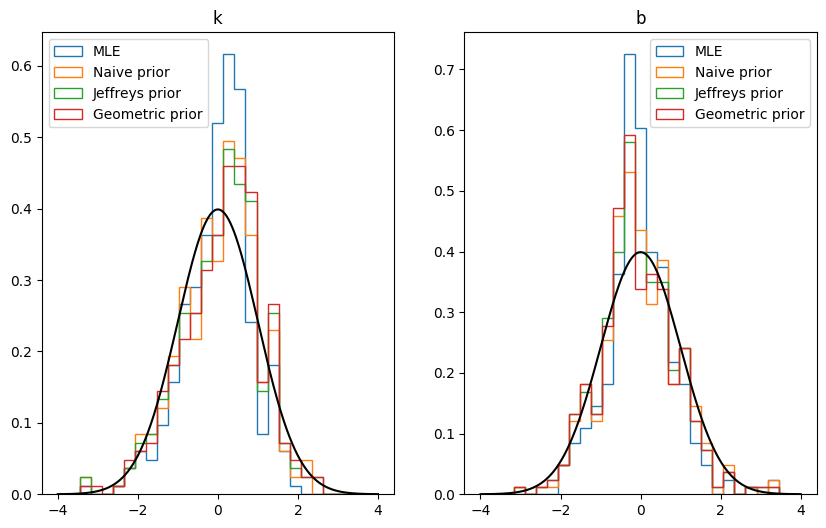

In [7]:
from scipy import stats


fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

for j, param in enumerate(("k", "b")):
    ax: Axes = axes[j]
    ax.set_title(param)
    z_bins = list(np.linspace(-4, 4, 30))
    for i, method in enumerate(
        ("MLE", "Naive prior", "Jeffreys prior", "Geometric prior")
    ):
        data = z_sample[i, j, :]  # type: ignore
        ax.hist(data, density=True, bins=z_bins, label=method, histtype="step")
    z_grid = np.linspace(-4, 4, 500)
    ax.plot(z_grid, stats.norm.pdf(z_grid), color="k")
    ax.legend()

fig.show()

In [14]:
np.sqrt(np.mean(z_sample ** 2, axis=2))


array([[0.81262534, 0.80498017],
       [0.96422381, 0.94066964],
       [0.96668271, 0.94039994],
       [0.96886639, 0.94328519]])